# Scaling ML using Cloud ML Engine

## Contents

1. Data Science Workflow
2. Where to develop?
3. Hands-ON Tutorial: Running MNIST on ML-Engine
   1. Setup
   2. Training Possibilities
   3. Evaluation 
   4. Deployment
4. Recap
5. Appendix
   1. Jupyter Slides

# 1. Data Science Workflow

- Goal is to standardise the development of models
     - Checklist of necessary technical steps

> Vision: Achieve an first end-to-end model in production within a *productincrement* of 10 weeks

> Scale out: Scale without having to rewrite your model

In [1]:
%%javascript // some javascript to render markdown tables properly

// from https://github.com/jupyter/notebook/issues/3024#issuecomment-435630413
var marked = require('components/marked/lib/marked');

if (marked.Renderer.name !== 'NonExtensibleTableRenderer') {
    function tablecell(content, flags) {
        var type = flags.header ? 'th' : 'td';
        var style = flags.align == null ? '' : ' style="text-align: ' + flags.align + '"';
        var start_tag = '<' + type + style + '>';
        var end_tag = '</' + type + '>\n';
        return start_tag + content + end_tag;
    }

    var DefaultRenderer = marked.Renderer;
    function NonExtensibleTableRenderer(options) {
        DefaultRenderer.call(this, options);
        Object.defineProperty(this, 'tablecell', {
            get: function () { return tablecell; },
            set: function () { } // No-op, sorry for this hack but we must prevent it from being redefined
        });
    }
    NonExtensibleTableRenderer.prototype = Object.create(DefaultRenderer.prototype);
    NonExtensibleTableRenderer.prototype.constructor = NonExtensibleTableRenderer;

    marked.setOptions({
        renderer: new NonExtensibleTableRenderer()
    });
    // Look away... it has to be done as newer versions of the notebook build a custom
    // renderer rather than extending the default.
    marked.Renderer = NonExtensibleTableRenderer;
}

var Jupyter = require('base/js/namespace');
Jupyter.notebook.get_cells()
   .filter(cell => cell.cell_type === 'markdown' && cell.rendered)
   .forEach(mdcell => {
       mdcell.unrender();
       mdcell.render();
   });

<IPython.core.display.Javascript object>


### Data Science Process - Proposal

|   Step 1: Preparation       |      Step 2: Data exploration and model building                   |    Step 3: Model deployment                    
|   :-----      |      :----                 |   :----
| 1.1  Project setup          | 2.1  One click to start the Data Scientist Exploration Environment | 3.1  Model serving                             
| 1.2  Quick data exploration | 2.2  Setup for Data exploration and Machine Learning               | 3.2  Model deployment (load balancing ...)     
| 1.3  Data visualization     | 2.3  Deep dive in data exploration                                 | 3.3  Model versioning                           
|        -                    | 2.4  Data visualization and profiling                              | 3.4  Model monitoring                          
|        -                    | 2.5  Feature engineering                                           |                        -                       
|        -                    | 2.6  Model building                                                |                        -                       
|        -                    | 2.7  Model training                                                |                        -                       
|        -                    | 2.8  Model testing                                                 |                        -                       
|        -                    | 2.9  Hyparameters tuning                                           |                        -                       
|        -                    | 2.10 Model visualisation                                           |                        -                       
> steps 1 and 2 can be done *only* locally

We will look today at
    - 2.7 How to train a model?
    - 2.8 How to evaluate a model?
    - 3.1 How to make predictions?
    - 3.2 How to deploy a model?

Should help to answer:
- Where do we need to improve?
- Where to go next?

> Process description will be refined.

# 2. Where to develop?

|SDK on local Machine | Google Console |
|---------------------|----------------|
| your machine | Tiny Compute Engine with 5 GB storage |
| Your IDE | Code Editor|
| Jupyter Notebook | Datalab |
| `gcloud ml-engine local` | `gcloud ml-engine`


Locally using
- Google SDK on your laptop (CLI)
- your IDE (e.g. PyCharme)
- Juypter Notebook
- `gcloud ml-engine local` 

Simple Cloud setup using
- [Google Console](https://console.cloud.google.com/) Compute Engine with 5 GB storage
- Cloud Editor
- datalab
- `gcloud ml-engine` (`local`)

## Proposal

- when to migrate to GCP:
   - distribute learning on several machines
   - serve model 24/7


> develop locally


# 3. Hands-ON Tutorial: Running MNIST on ML-Engine

- deep dive into step 2 and 3 of Data Science process
- data exploration is omitted as a curated dataset is used

Adapted from [Notebook](https://github.com/GoogleCloudPlatform/training-data-analyst/blob/master/courses/machine_learning/cloudmle/cloudmle.ipynb) of Google Coursera Course [Serverless Machine Learning with Tensorflow on Google Cloud Platform](https://www.coursera.org/learn/serverless-machine-learning-gcp/)

- In order to import from `src` functionality later in this notebook, it is necessary to change to the root directory of the notebooks directory

In [7]:
# check working directory
import os
WORKINGDIR = os.getcwd()
print("Current Working direcotory:\t{}".format(WORKINGDIR))
folders = WORKINGDIR.split('/')
if folders.pop() == 'notebook':  # or a list: in ['notebook', 'src', etc.]
  WORKINGDIR = '/'.join(folders)
  print("Changed to New working directory:\t{}".format(WORKINGDIR))
  os.chdir(WORKINGDIR) 

Current Working direcotory:	/home/enryh/gcp_ml_engine_talk


## MNIST use-case

#### Create an test-image in numpy format saved as json (copy from test set)

In [38]:
# Create a file with 4 test images
N=4
import numpy as np
import json
from src.pkg_mnist_fnn.utils import load_data
from src.pkg_mnist_fnn.model import parse_images
(_,_), (x_test, y_test) = load_data(rel_path='data')
test_indices = np.random.randint(low=0, high=len(y_test), size=N)
x_test, y_test = x_test[test_indices], y_test[test_indices]
x_test = parse_images(x_test).tolist()

eol = "\r\n"
n_lines = len(y_test)
with open("data/test.json", "w") as f:
    for image, label in zip(x_test, y_test):
        _dict = {"x": image} #, "y": int(label)}
        f.write(json.dumps(_dict) + eol)

Loaded data from /home/enryh/proj_DL_models_and_pipelines_with_GCP/data/mnist.npz


- recognise hand-written digits (e.g. on a postal card) 

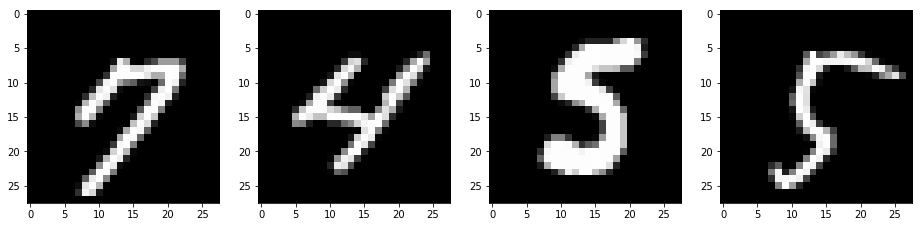

In [9]:
from src.utils.mnist_utils import plot_mnist_testdata 
plot_mnist_testdata()

![](https://ml4a.github.io/images/figures/mnist-input.png)

Why MNIST?
- images need pre-processing
- black and white images are numeric vectors

## 3.A Setup

1. ML Engine Runtimes
2. Repository Structure
3. Configuration Variables
    -  Environment variables to set
    - How to add them to your runtime
4. Setup `gcloud` runtime

Create conda environement
  - `conda env create -f environment.yml -n env_gcp_dl`

### 1 ML Engine Runtimes
Default ML-Engine Runtimes depend on the Tensorflow Version
- [list of runtimes](https://cloud.google.com/ml-engine/docs/tensorflow/runtime-version-list)
- Current Version: `1.12`

In [ ]:
#!pip install tensorflow=1.12

In [10]:
import tensorflow as tf
tf.__version__

'1.12.0'

In [12]:
%%bash
source activate gcp_dl
TF_VERSION=$(python3 -c 'import tensorflow as tf; print(tf.__version__)')
if $TF_VERSION != "1.12.0"
then
    pip install tensorflow==1.12
fi
    echo "Found Tensorflow: $TF_VERSION"

Found Tensorflow: 1.12.0


bash: line 3: 1.12.0: command not found


- current version of gcp datalab
- will be different on Windows machines


### 2. Repository structure

In [11]:
ls | grep "/\|yaml"

config.yaml
data/
doc/
notebook/
src/
test/
trained/


Key Directories containing information
```
.
+-- data
+-- src
|  +-- models
|  +-- packages
config.yaml
```

In the next step the contents of [`config.yaml`](config.yaml) will be important

In [7]:
!cat config.yaml

project-id: ml-productive-pipeline-53122
region: europe-west1
bucket: ml-productive-pipeline-53122
tf-version: 1.12
pkg-name: pkg_mnist_fnn

### 3. GCP Environment Variables

- `PROJECT_ID`: unique ID that identifies your project, e.g. **ml-productive-pipeline-12345**
- `BUCKET`: BLOB-store ID. Each project has per default an bucket named by the `PROJECT_ID`
- `REGION`: Which data center to use

In [ ]:
# # #Create config manually and save as yaml:
# config = {}
# config['project-id'] = 'PROJECT'  # # REPLACE WITH YOUR PROJECT ID
# config['region'] = 'europe-west1' # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.
# config['bucket'] = 'Bucket-name'  # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
# 
# with open("../config_from_python.yaml", 'wb', encoding= 'utf8') as f:
#     yaml.dump(f)

Additional Environment Variables needed for ML-Engine
- `PKG_NAME`: Package Name which will contain your model
- `TF_VERSION`: Tensorflow Version

In [12]:
import yaml
from pprint import pprint
with open("config.yaml", "r", encoding = "utf8") as f:
    config = yaml.load(f)
pprint(config)

{'bucket': 'ml-productive-pipeline-53122',
 'pkg-name': 'pkg_mnist_fnn',
 'project-id': 'ml-productive-pipeline-53122',
 'region': 'europe-west1',
 'tf-version': 1.12}


#### Environment variables for project and bucket

Note that:
1. Your project id is the *unique* string that identifies your project (not the project name). You can find this from the GCP Console dashboard's Home page. My dashboard reads:  
     
     - Project ID: ml-productive-pipeline-12345
     
2. Cloud training often involves saving and restoring model files. If you don't have a bucket already, I suggest that you create one from the GCP console (because it will dynamically check whether the bucket name you want is available). A common pattern is to prefix the bucket name by the project id, so that it is unique. Also, for cost reasons, you might want to use a single region bucket.


Add all detail in to [config.yaml](../config.yaml) file in main directory. Missing in public repository.


#### Adding Environment Variables to your runtime
- add variables **persistently**  to the runtime of your kernel from jupyter (or datalab)
- use `os.environ` dictionary

In [13]:
import os
PROJECT = config['project-id'] 
REGION = config['region'] # Choose an available region for Cloud MLE from https://cloud.google.com/ml-engine/docs/regions.
BUCKET = config['bucket'] # REPLACE WITH YOUR BUCKET NAME. Use a regional bucket in the region you selected.
PKG_NAME = config['pkg-name']

os.environ['PROJECT'] = PROJECT
os.environ['BUCKET'] = BUCKET
os.environ['REGION'] = REGION
os.environ['TFVERSION'] = str(config['tf-version'])  # Tensorflow version 1.4 before
os.environ['PKG_NAME'] = config['pkg-name']

Now, you can access the environement variable in the terminal where your jupyter, datalab or iphyton.

In [14]:
!echo "Using Tensorflow Version: $TFVERSION"

Using Tensorflow Version: 1.12


### 4. Setup gcloud runtime


In [15]:
%%bash
gcloud config set project $PROJECT
gcloud config set compute/region $REGION

Updated property [core/project].
Updated property [compute/region].


### Access Control 

- not necessary if you use 
  - datalab
  - local sdk

- Service Accounts ([Creating and Managing Service Accounts](https://cloud.google.com/iam/docs/creating-managing-service-accounts))
  - need be assigned read/write permission to `BUCKET`

In [12]:
%%bash
source activate gcp_dl
PROJECT_ID=$PROJECT
AUTH_TOKEN=$(gcloud auth print-access-token)
#echo "Auth-Token: $AUTH_TOKEN
SVC_ACCOUNT=$(curl -X GET -H "Content-Type: application/json" \
    -H "Authorization: Bearer $AUTH_TOKEN" \
    https://ml.googleapis.com/v1/projects/${PROJECT_ID}:getConfig \
    | python -c "import json; import sys; response = json.load(sys.stdin); \
    print(response['serviceAccount'])")
echo "Current Service Account of VM: $SVC_ACCOUNT"
echo "Authorizing the Cloud ML Service account $SVC_ACCOUNT to access files in Bucket: $BUCKET"
gsutil -m defacl ch -u $SVC_ACCOUNT:R gs://$BUCKET
gsutil -m acl ch -u $SVC_ACCOUNT:R -r gs://$BUCKET # error message (if bucket is empty) can be ignored
gsutil -m acl ch -u $SVC_ACCOUNT:W gs://$BUCKET

Process is terminated.


## Beyond Scripting: Packaging up the code

 
Why a package?
 - can be called from other scripts `import model`

Take your code and put into a standard Python package structure, see  [pkg_mnist_fnn/model.py](../src/pkg_mnist_fnn/model.py)

Key-Idea: 
 - define entry point which can be called
 - write all tasks as a function (callable)

### `model.py`

In [ ]:
# %load src/pkg_mnist_fnn/model.py
"""
First try to start Cloud ML

References:
Basic reference for packaging the model so that ml-engine can use it:
- https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/machine_learning/cloudmle/taxifare
MNIST-Estimator-Example:
- https://codeburst.io/use-tensorflow-dnnclassifier-estimator-to-classify-mnist-dataset-a7222bf9f940

ipython -i -m src.models.test_model_estimator_api.mnist_ml_engine -- --data_path=data --output_dir=src\models\test_model_estimator_api\trained --train_steps=100
"""

import tensorflow as tf
import numpy as np

from .utils import load_data
###############################################################################
#Factor into config:
N_PIXEL = 784
OUTDIR = 'trained'
USE_TPU = False
EPOCHS = 5

if USE_TPU:
    _device_update = 'tpu'
else:
    _device_update = 'cpu'

IMAGE_SIZE = 28 * 28
NUM_LABELS = 10
BATCH_SIZE = 128
###############################################################################


def parse_images(x):
    return x.reshape(len(x), -1).astype('float32')


def parse_labels(y):
    return y.astype('int32')


def numpy_input_fn(images: np.ndarray,
                   labels: np.ndarray,
                   mode=tf.estimator.ModeKeys.EVAL):
    """
    Return depending on the `mode`-key an Interator which can be use to feed into
    the Estimator-Model. 

    Alternative if a `tf.data.Dataset` named `dataset` would be created:
    `dataset.make_one_shot_iterator().get_next()`
    """
    if mode == tf.estimator.ModeKeys.TRAIN:
        _epochs = EPOCHS
        _shuffle = True
        _num_threads = 2
    else:
        _epochs = 1
        _shuffle = False
        _num_threads = 1

    return tf.estimator.inputs.numpy_input_fn(
        {'x': images},
        y=labels,
        batch_size=BATCH_SIZE,
        num_epochs=_epochs,
        # Boolean, if True shuffles the queue. Avoid shuffle at prediction time.
        shuffle=_shuffle,
        queue_capacity=1000,
        # Integer, number of threads used for reading and enqueueing. In order to have predicted and repeatable order of reading and enqueueing, such as in prediction and evaluation mode, num_threads should be 1.
        num_threads=_num_threads
    )


def serving_input_fn():
    feature_placeholders = {
        'x': tf.placeholder(tf.float32, shape=[None, N_PIXEL])
    }
    features = feature_placeholders
    return tf.estimator.export.ServingInputReceiver(
         features=features, 
         receiver_tensors=feature_placeholders,
         receiver_tensors_alternatives=None
         )


def train_and_evaluate(args):
    """
    Utility function for distributed training on ML-Engine
    https://www.tensorflow.org/api_docs/python/tf/estimator/train_and_evaluate 
    """
    ##########################################
    # Load Data in Memoery
    # ToDo: replace numpy-arrays
    (x_train, y_train), (x_test, y_test) = load_data(
        rel_path=args['data_path'])
  
    x_train = parse_images(x_train)
    x_test = parse_images(x_test)

    y_train = parse_labels(y_train)
    y_test = parse_labels(y_test)

    model = tf.estimator.DNNClassifier(
        hidden_units=[256, 128, 64],
        feature_columns=[tf.feature_column.numeric_column(
            'x', shape=[N_PIXEL, ])],
        model_dir=args['output_dir'],
        n_classes=10,
        optimizer=tf.train.AdamOptimizer,
        # activation_fn=,
        dropout=0.2,
        batch_norm=False,
        loss_reduction='weighted_sum',
        warm_start_from=None,
        config = None
    )
   
    train_spec = tf.estimator.TrainSpec(
        input_fn=numpy_input_fn(
            x_train, y_train, mode=tf.estimator.ModeKeys.TRAIN),
        max_steps=args['train_steps'],
        hooks = None
    )
    exporter = tf.estimator.LatestExporter('exporter', serving_input_fn)
    eval_spec = tf.estimator.EvalSpec(
        input_fn=numpy_input_fn(
            x_test, y_test, mode=tf.estimator.ModeKeys.EVAL),
        steps=None,
        start_delay_secs=args['eval_delay_secs'],
        throttle_secs=args['min_eval_frequency'],
        exporters=exporter
    )
    tf.estimator.train_and_evaluate(
        estimator=model, train_spec=train_spec, eval_spec=eval_spec)

### `task.py`

In [ ]:
# %load src/pkg_mnist_fnn/task.py
"""
Parse arguments and call main function
"""
import os
import argparse
import shutil

from .model import train_and_evaluate

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument(
        '--data_path',
        help='GCS or local path to training data',
        required=True
    )
    parser.add_argument(
        '--output_dir',
        help='GCS location to write checkpoints and export models',
        required=True
    )
    parser.add_argument(
        '--train_batch_size',
        help='Batch size for training steps',
        type=int,
        default='128'
    )
    parser.add_argument(
        '--train_steps',
        help='Steps to run the training job for',
        type=int,
        default='200'
    )
    parser.add_argument(
        '--hidden_units',
        help='List of hidden layer sizes to use for DNN feature columns',
        nargs='+',
        type=int,
        default=[128, 64, 32]
    )
    parser.add_argument(
        '--job_dir',
        help='this model ignores this field, but it is required by gcloud',
        default='junk'
    )
    # Eval arguments
    parser.add_argument(
        '--eval_delay_secs',
        help='How long to wait before running first evaluation',
        default=1,
        type=int
    )
    parser.add_argument(
        '--min_eval_frequency',
        help='Seconds between evaluations',
        default=10,
        type=int
    )

    args = parser.parse_args().__dict__

    OUTDIR = args['output_dir']
    # #######################################
    # # Train and Evaluate (use TensorBoard to visualize)
    train_and_evaluate(args)

# 3.B Train using ML-Engine on

### your local machine
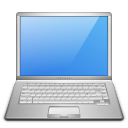 

1. Call your python script (module)
2. Use `gcloud ml-engine local train`

### a cluster of machines using ML-Engine service

3. Use `gcloud ml-engine train`

### Modeling and ML-Engine

- Environment Variables with absolut paths to relevant folders: 
    - `PWD`: where your project folder lies
    - `PKG_NAME`: Self-Contained Package to be exported into `site-packages` in `venv`
    - `trained`: Where to store checkpoints (logs, weights, graph)

In [99]:
%%bash
echo "Working Directory:     $PWD"
echo "Local data Directory:  $PWD/data"
echo "Package Directory:     $PWD/src/$PKG_NAME"
echo "Saved Model Directory: $PWD/src/$PKG_NAME/trained/"
rm -rf $PWD/src/$PKG_NAME/trained/ # start fresh
echo "Erased previously saved models"

Working Directory:     /home/enryh/proj_DL_models_and_pipelines_with_GCP
Local data Directory:  /home/enryh/proj_DL_models_and_pipelines_with_GCP/data
Package Directory:     /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn
Saved Model Directory: /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained/
Erased previously saved models


## 1. Running the Python `module` without gcp ml-engine

- Entry point is defined in `task.py`
  - parses command line arguments 
- conda env has to be active

In [100]:
%%bash
source activate gcp_dl
rm -rf $PKG_NAME.tar.gz ${PWD}/$PKG_NAME/trained
export PYTHONPATH=${PYTHONPATH}:${PWD}/../  
echo "Python Package Path: src.${PKG_NAME}.task"

Python Package Path: src.pkg_mnist_fnn.task


In [125]:
%%bash
source activate gcp_dl
python -m src.${PKG_NAME}.task \
   --data_path="${PWD}/data" \
   --output_dir=${PWD}/src/${PKG_NAME}/trained \
   --train_steps=1000 \
   --job_dir=tmp
echo "Saved model: ${PWD}/src/${PKG_NAME}/trained/export/exporter/ "

Saved model: /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained/export/exporter/ 


#### Saved Model

In [136]:
%%bash
DATE=$(ls $PWD/src/$PKG_NAME/trained/export/exporter/ |tail -1)
echo "Date as integer: $DATE"
echo 
date -d @${DATE}

Date as integer: 1551195228

Tue Feb 26 16:33:48 CET 2019


#### And we would be ready to deploy

... but of course not without looking at performance metrics or predictions!

In [ ]:
ls $PWD/src/$PKG_NAME/trained/export/exporter/

## 2. Training using `gcloud ml-engine local train`

- continue training using `ml-engine local`

In [105]:
%%bash
source activate gcp_dl
gcloud ml-engine local train \
   --module-name=${PKG_NAME}.task \
   --package-path=${PWD}/src/${PKG_NAME} \
   -- \
   --data_path="${PWD}/data" \
   --output_dir=${PWD}/src/${PKG_NAME}/trained \
   --train_steps=2000 \
   --job_dir=./tmp

In [9]:
!gcloud ml-engine local train  --help

NAME
    gcloud ml-engine local train - run a Cloud ML Engine training job locally

SYNOPSIS
    gcloud ml-engine local train --module-name=MODULE_NAME [--distributed]
        [--job-dir=JOB_DIR] [--package-path=PACKAGE_PATH]
        [--parameter-server-count=PARAMETER_SERVER_COUNT]
        [--start-port=START_PORT; default=27182] [--worker-count=WORKER_COUNT]
        [GCLOUD_WIDE_FLAG ...] [-- USER_ARGS ...]

DESCRIPTION
    This command runs the specified module in an environment similar to that of
    a live Cloud ML Engine Training Job.

    This is especially useful in the case of testing distributed models, as it
    allows you to validate that you are properly interacting with the Cloud ML
    Engine cluster configuration. If your model expects a specific number of
    parameter servers or workers (i.e. you expect to use the CUSTOM machine
    type), use the --parameter-server-count and --worker-count flags to further
    specify the desired cluster configuration, just as you wo

## Training Cloud using `gcloud ml-engine train`

- a copy of the data is in Google Storage (buckets)
- `gcloud ml-engine` output is saved to `OUTDIR`in Google Storage 
  - checkpoints (logs)
  - model graph and weights
- data is copied to Google Storage
  
> NOTE: No with-spaces behind line break symbol **\**


In [39]:
!gsutil -m rm -rf gs://$BUCKET/$PKG_NAME/*

Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/#1550487114291535...
/ [1/1 objects] 100% Done                                                       
Operation completed over 1 objects.                                              


In [40]:
# 10 epochs in global steps:

steps = 10000
batch_size = 128
n_train = 60000
print("Number of epochs using {} steps: {:.1f}".format(steps, steps * batch_size / n_train))
steps = int(60000 / 128 * 10) + 1
print("For ten epochs specify {} steps".format(steps))

Number of epochs using 10000 steps: 21.3
For ten epochs specify 4688 steps


In [106]:
OUTDIR = '/'.join(['gs:/', BUCKET, PKG_NAME, 'trained'])
os.environ['OUTDIR'] = OUTDIR

In [139]:
!gsutil -m cp ${PWD}/data/mnist/raw/mnist.npz gs://${BUCKET}/$PKG_NAME/data/mnist.npz

Copying file:///home/enryh/proj_DL_models_and_pipelines_with_GCP/data/mnist/raw/mnist.npz [Content-Type=application/octet-stream]...
/ [1/1 files][ 11.0 MiB/ 11.0 MiB] 100% Done                                    
Operation completed over 1 objects/11.0 MiB.                                     


In [107]:
%%bash
OUTDIR=gs://${BUCKET}/$PKG_NAME/trained
JOBNAME=mnist_$(date -u +%y%m%d_%H%M%S)
echo $OUTDIR $REGION $JOBNAME
gsutil -m rm -rf $OUTDIR
gcloud ml-engine jobs submit training $JOBNAME \
   --region=$REGION \
   --module-name=$PKG_NAME.task \
   --package-path=${PWD}/src/$PKG_NAME \
   --staging-bucket=gs://$BUCKET \
   --scale-tier=BASIC \
   --python-version 3.5 \
   --runtime-version=$TFVERSION \
   -- \
   --data_path="gs://${BUCKET}/$PKG_NAME/data/" \
   --output_dir=$OUTDIR \
   --train_steps=5000 \
   --job_dir=$OUTDIR/jobs 

gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained europe-west1 mnist_190226_153903
jobId: mnist_190226_153903
state: QUEUED


Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/#1551189625396791...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/checkpoint#1551189632535194...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/eval/events.out.tfevents.1551189555.cmle-training-15024654005366275538#1551189558325794...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/eval/#1551189555184899...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/events.out.tfevents.1551189473.cmle-training-15024654005366275538#1551189583874752...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/eval/events.out.tfevents.1551189639.cmle-training-2556488161313260297#1551189642061761...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/events.out.tfevents.1551189596.cmle-training-2556488161313260297#1551189666903395...
Removing gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/export/#1551189561488413...
Removing gs://ml-produ

### Fetch logs from ml-engine job

In [46]:
!gcloud ml-engine jobs describe    mnist_190226_135612

createTime: '2019-02-26T13:56:16Z'
etag: xa9JtMyFgys=
jobId: mnist_190226_135612
startTime: '2019-02-26T13:57:04Z'
state: RUNNING
trainingInput:
  args:
  - --data_path=gs://ml-productive-pipeline-53122/pkg_mnist_fnn/
  - --output_dir=gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained
  - --train_steps=5000
  - --job_dir=gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/jobs
  packageUris:
  - gs://ml-productive-pipeline-53122/mnist_190226_135612/dbf14cd8277aeba054056ee160e13d2f2d798a9f82dfd5b3b76d289e7a0284c8/pkg_mnist_fnn-0.0.0.tar.gz
  pythonModule: pkg_mnist_fnn.task
  pythonVersion: '3.5'
  region: europe-west1
  runtimeVersion: '1.12'
trainingOutput:
  consumedMLUnits: 0.03

View job in the Cloud Console at:
https://console.cloud.google.com/ml/jobs/mnist_190226_135612?project=ml-productive-pipeline-53122

View logs at:
https://console.cloud.google.com/logs?resource=ml.googleapis.com%2Fjob_id%2Fmnist_190226_135612&project=ml-productive-pipeline-53122


In [47]:
!gcloud ml-engine jobs stream-logs mnist_190226_135612

INFO	2019-02-26 14:56:16 +0100	service		Validating job requirements...
INFO	2019-02-26 14:56:16 +0100	service		Job creation request has been successfully validated.
INFO	2019-02-26 14:56:16 +0100	service		Waiting for job to be provisioned.
INFO	2019-02-26 14:56:16 +0100	service		Job mnist_190226_135612 is queued.
INFO	2019-02-26 14:56:21 +0100	service		Waiting for training program to start.
INFO	2019-02-26 14:57:30 +0100	master-replica-0		Running task with arguments: --cluster={"master": ["127.0.0.1:2222"]} --task={"type": "master", "index": 0} --job={  "package_uris": ["gs://ml-productive-pipeline-53122/mnist_190226_135612/dbf14cd8277aeba054056ee160e13d2f2d798a9f82dfd5b3b76d289e7a0284c8/pkg_mnist_fnn-0.0.0.tar.gz"],  "python_module": "pkg_mnist_fnn.task",  "args": ["--data_path\u003dgs://ml-productive-pipeline-53122/pkg_mnist_fnn/", "--output_dir\u003dgs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained", "--train_steps\u003d5000", "--job_dir\u003dgs://ml-productive-pipeline-53122/

INFO	2019-02-26 14:58:16 +0100	master-replica-0		global_step/sec: 125.445
INFO	2019-02-26 14:58:16 +0100	master-replica-0		loss = 175.5782, step = 201 (0.793 sec)
INFO	2019-02-26 14:58:17 +0100	master-replica-0		global_step/sec: 128.56
INFO	2019-02-26 14:58:17 +0100	master-replica-0		loss = 137.81128, step = 301 (0.778 sec)
INFO	2019-02-26 14:58:17 +0100	master-replica-0		global_step/sec: 125.089
INFO	2019-02-26 14:58:17 +0100	master-replica-0		loss = 103.07169, step = 401 (0.799 sec)
INFO	2019-02-26 14:58:18 +0100	master-replica-0		global_step/sec: 118.506
INFO	2019-02-26 14:58:18 +0100	master-replica-0		loss = 120.83708, step = 501 (0.844 sec)
INFO	2019-02-26 14:58:19 +0100	master-replica-0		global_step/sec: 124.731
INFO	2019-02-26 14:58:19 +0100	master-replica-0		loss = 76.74655, step = 601 (0.802 sec)
INFO	2019-02-26 14:58:20 +0100	master-replica-0		global_step/sec: 112.614
INFO	2019-02-26 14:58:20 +0100	master-replica-0		loss = 63.736683, step = 701 (0.888 sec)
INFO	2019-02-26 14:

INFO	2019-02-26 14:59:23 +0100	master-replica-0		Signatures INCLUDED in export for Predict: ['predict']
INFO	2019-02-26 14:59:23 +0100	master-replica-0		Signatures INCLUDED in export for Eval: None
INFO	2019-02-26 14:59:23 +0100	master-replica-0		Signatures EXCLUDED from export because they cannot be be served via TensorFlow Serving APIs:
INFO	2019-02-26 14:59:23 +0100	master-replica-0		'classification' : Classification input must be a single string Tensor; got {'x': <tf.Tensor 'Placeholder:0' shape=(?, 784) dtype=float32>}
INFO	2019-02-26 14:59:23 +0100	master-replica-0		'serving_default' : Classification input must be a single string Tensor; got {'x': <tf.Tensor 'Placeholder:0' shape=(?, 784) dtype=float32>}
WARNING	2019-02-26 14:59:23 +0100	master-replica-0		Export includes no default signature!
INFO	2019-02-26 14:59:23 +0100	master-replica-0		Restoring parameters from gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/model.ckpt-4688
WARNING	2019-02-26 14:59:24 +0100	master-re

Don't be concerned if the notebook appears stalled (with a blue progress bar) or returns with an error about being unable to refresh auth tokens. This is a long-lived Cloud job and work is going on in the cloud. 

**Use the Cloud Console link to monitor the job and do NOT proceed until the job is done.**

## Check Results in TensorBoard

- In Datalab Tensorboard is available using a special package. On your local machine, you can execute tensorflow using the command line.

In Datalab Tensorboard is available using a special package. On your local machine, you can execute tensorflow using the command line.

DATALAB:

In [ ]:
from google.datalab.ml import TensorBoard
TensorBoard().start(('{}/'+os.environ['PKG_NAME']).format(os.environ['PWD']))

In [ ]:
for pid in TensorBoard.list()['pid']:
  TensorBoard().stop(pid)
  print('Stopped TensorBoard with pid {}'.format(pid))

If the above step (to stop TensorBoard) appears stalled, just move on to the next step. You don't need to wait for it to return.

Local Machine: `tensorboard --logdir /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained`

In [59]:
%%bash
source activate gcp_dl
tensorboard --logdir $PWD/src/$PKG_NAME/trained

Process is terminated.


In [60]:
!echo "tensorboard --logdir $PWD/src/$PKG_NAME/trained"

tensorboard --logdir /home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained


In [ ]:
%%bash
#gcloud auth application-default login
echo $OUTDIR
tensorboard --logdir $OUTDIR

# Deploy model - from any previous step

- `tf.estimator.LatestExporter`is used to store a model for deployment in the cloud
- See also:  `tf.estimator.export`, `tf.saved_model`

[Link to Console](https://console.cloud.google.com/)

In [115]:
%%bash
gsutil ls gs://${BUCKET}/${PKG_NAME}/trained/export/exporter 

gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/export/exporter/
gs://ml-productive-pipeline-53122/pkg_mnist_fnn/trained/export/exporter/1551195744/


Identifier for deployed model:
- `MODEL_NAME`
- `MODEL_VERSION`

In [111]:
%%bash
MODEL_NAME="MNIST_MLENGINE"
MODEL_VERSION="v3" 
MODEL_LOCATION=$(gsutil ls gs://${BUCKET}/$PKG_NAME/trained/export/exporter | tail -1)
echo "Run these commands one-by-one (the very first time, you'll create a model and then create a version)"
#gcloud ml-engine versions delete ${MODEL_VERSION} --model ${MODEL_NAME}
#gcloud ml-engine models delete ${MODEL_NAME}
gcloud ml-engine models   create ${MODEL_NAME} --regions $REGION
gcloud ml-engine versions create ${MODEL_VERSION} --model ${MODEL_NAME} --origin ${MODEL_LOCATION} --runtime-version $TFVERSION

Run these commands one-by-one (the very first time, you'll create a model and then create a version)


ERROR: (gcloud.ml-engine.models.create) Resource in project [ml-productive-pipeline-53122] is the subject of a conflict: Field: model.name Error: A model with the same name already exists.
- '@type': type.googleapis.com/google.rpc.BadRequest
  fieldViolations:
  - description: A model with the same name already exists.
    field: model.name
Creating version (this might take a few minutes)......
..............................................................................................done.


# Predictions

1. Using the Model saved by Python Module
2. Using Model saved by `ml-engine local`
3. Using Model trained online

Tools get predictions:
- Command Line Interfaces
    - `gcloud ml-engine local predict`
    - `gcloud ml-engine predict`
- Python Client

### Let's look again at our four examples

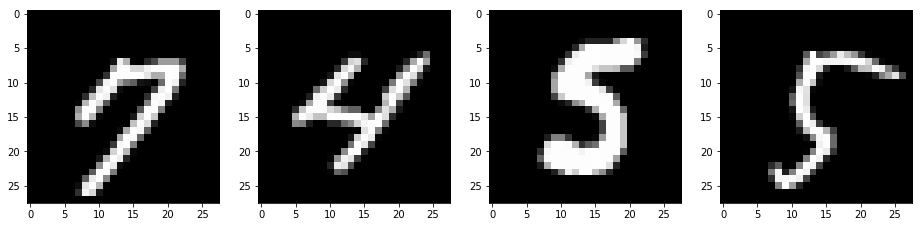

In [64]:
from src.utils.mnist_utils import plot_mnist_testdata
plot_mnist_testdata()

## ML-Engine: `ml-engine local predict`
- Using Model saved
  - Python module
  - `ml-engine local`

### `ML-Engine local` using Python 3 ...
you still have to remove manually some compiled python files

In [ ]:
!ls /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/

In order to work with `Python 3`, delete the `*.pyc` files, see [post](https://stackoverflow.com/questions/48824381/gcloud-ml-engine-local-predict-runtimeerror-bad-magic-number-in-pyc-file)

Default Datalab
```
rm /tools/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
```
Default UNIX:
```
sudo rm /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
```

> Process running Datalab or Jupyter Notebook needs admin rights. This is not always given for locally run notebooks

In [ ]:
%%bash
# #remove any pyc files: Using Python3 you have to recompile
# #Note: you need admin rights
rm /tools/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc
# sudo rm /usr/lib/google-cloud-sdk/lib/googlecloudsdk/command_lib/ml_engine/*.pyc 

In [117]:
%%bash
source activate gcp_dl
model_dir=$(ls $PWD/src/$PKG_NAME/trained/export/exporter/ | tail -1)
echo "Selected Model:  $model_dir" 
gcloud ml-engine local predict \
    --model-dir=${PWD}/src/${PKG_NAME}/trained/export/exporter/${model_dir} \
    --json-instances=./data/test.json \
    --verbosity debug > data/test_predictions
cat data/test_predictions

Selected Model:  1551195228
CLASS_IDS  CLASSES  LOGITS                                                                                                                                                                                                    PROBABILITIES
[7]        [u'7']   [10.159305572509766, 12.954800605773926, 11.682648658752441, 13.86036205291748, 25.222925186157227, 7.880295276641846, -3.0875470638275146, 39.66598892211914, 10.021535873413086, 31.613039016723633]    [1.5320462455094275e-13, 2.508069489939868e-12, 7.028310767577539e-13, 6.2032701024505865e-12, 5.337264497029537e-07, 1.5685923629329794e-14, 2.705433004601221e-19, 0.9996814727783203, 1.334870934491597e-13, 0.0003180606581736356]
[4]        [u'4']   [15.225436210632324, 9.730201721191406, 23.877195358276367, 10.366071701049805, 55.04463195800781, 25.375831604003906, 4.700004577636719, 11.3602294921875, 20.23716926574707, 36.84248352050781]         [5.0903007448063715e-18, 2.09022482340398e-20, 2.911751311525

DEBUG: Running [gcloud.ml-engine.local.predict] with arguments: [--json-instances: "./data/test.json", --model-dir: "/home/enryh/proj_DL_models_and_pipelines_with_GCP/src/pkg_mnist_fnn/trained/export/exporter/1551195228", --verbosity: "debug"]
2019-02-26 16:48:35.700984: I tensorflow/core/common_runtime/process_util.cc:69] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.

INFO: Display format: "default 
          table(
              predictions:format="table(
                  class_ids, classes, logits, probabilities
              )"
          )"
DEBUG: SDK update checks are disabled.


In [ ]:
%%bash
gcloud ml-engine local predict --help

## Online Prediction - Command Line

- same output format as before

In [118]:
%%bash
gcloud ml-engine predict --model=MNIST_MLENGINE --version=v1 --json-instances=data/test.json

CLASS_IDS  CLASSES  LOGITS                                                                                                                                                                                                    PROBABILITIES
[7]        [u'7']   [22.002077102661133, 4.273345470428467, 24.17157745361328, 24.138999938964844, 28.22089195251465, 23.208688735961914, 3.522111415863037, 42.038028717041016, 16.697460174560547, 34.3787841796875]        [1.9874284440390966e-09, 3.970099341190314e-17, 1.739776855913533e-08, 1.6840123961969766e-08, 9.97903271127143e-07, 6.6422662925447185e-09, 1.8730255928538357e-17, 0.9995274543762207, 9.874739914650377e-12, 0.00047144072595983744]
[4]        [u'4']   [11.610347747802734, 10.453926086425781, 18.951528549194336, 3.513504981994629, 41.507911682128906, 4.462229251861572, 18.024948120117188, 25.706693649291992, 16.08464241027832, 24.898889541625977]     [1.036699412838675e-13, 3.261559655708991e-14, 1.5991424850980707e-10, 3.156736284461617

> Check Console

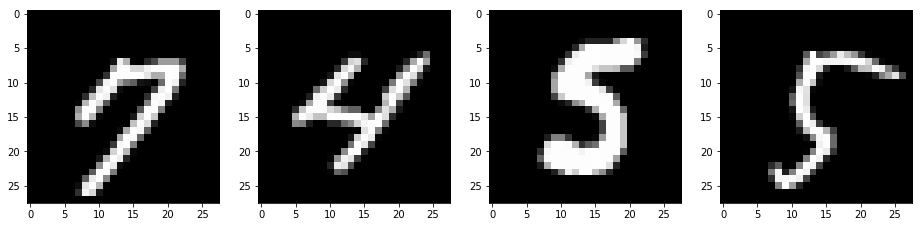

In [85]:
plot_mnist_testdata()

## Online Prediction - Python Client

- Get predictions using the [Python-Client-Library, see Tutorial](https://cloud.google.com/ml-engine/docs/tensorflow/python-client-library). 

- [API-Reference](https://cloud.google.com/ml-engine/reference/rest/)

-  service account authentification:  [link](https://cloud.google.com/iam/docs/creating-managing-service-accounts)

In [ ]:
# %bash
# export GOOGLE_APPLICATION_CREDENTIALS=$PWD/ML-productive-pipeline-53122-64d3c31786e7.json
# echo $GOOGLE_APPLICATION_CREDENTIALS

In [ ]:
# os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/content/datalab/proj_DL_models_and_pipelines_with_GCP/notebook/../ML-productive-pipeline-53122-64d3c31786e7.json'

In [119]:
from oauth2client.client import GoogleCredentials
from googleapiclient import discovery
from googleapiclient import errors
import json

In [8]:
%pdoc discovery.build

```
Signature: discovery.build(serviceName, version, http=None, discoveryServiceUrl='https://www.googleapis.com/discovery/v1/apis/{api}/{apiVersion}/rest', developerKey=None, model=None, requestBuilder=<class 'googleapiclient.http.HttpRequest'>, credentials=None, cache_discovery=True, cache=None)
Docstring:
Construct a Resource for interacting with an API.

Construct a Resource object for interacting with an API. The serviceName and
version are the names from the Discovery service.

Args:
serviceName: string, name of the service.
version: string, the version of the service.
http: httplib2.Http, An instance of httplib2.Http or something that acts
like it that HTTP requests will be made through.
discoveryServiceUrl: string, a URI Template that points to the location of
the discovery service. It should have two parameters {api} and
{apiVersion} that when filled in produce an absolute URI to the discovery
document for that service.
developerKey: string, key obtained from
https://code.google.com/apis/console.
model: googleapiclient.Model, converts to and from the wire format.
requestBuilder: googleapiclient.http.HttpRequest, encapsulator for an HTTP
request.
credentials: oauth2client.Credentials or
google.auth.credentials.Credentials, credentials to be used for
authentication.
cache_discovery: Boolean, whether or not to cache the discovery doc.
cache: googleapiclient.discovery_cache.base.CacheBase, an optional
cache object for the discovery documents.

Returns:
A Resource object with methods for interacting with the service.
File: /usr/local/envs/py3env/lib/python3.5/site-packages/googleapiclient/discovery.py
Type: function
```

In [120]:
api = discovery.build(serviceName='ml', version='v1',
                      http=None, 
                      discoveryServiceUrl='https://www.googleapis.com/discovery/v1/apis/{api}/{apiVersion}/rest', 
                      developerKey=None, 
                      model=None, 
                      #requestBuilder=<class 'googleapiclient.http.HttpRequest'>, 
                      credentials=None, 
                      cache_discovery=True, 
                      cache=None)

/home/enryh/miniconda3/envs/gcp_dl/lib/python3.6/site-packages/google/auth/_default.py:66: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


In [121]:
MODEL_NAME = 'MNIST_MLENGINE'
VERSION = 'v1'

In [122]:
# Load data
from src.pkg_mnist_fnn.utils import load_data
from src.pkg_mnist_fnn.model import parse_images
(_,_), (x_test, y_test) = load_data(rel_path='data')
N=4
test_indices = np.random.randint(low=0, high=len(y_test), size=N)
x_test, y_test = x_test[test_indices], y_test[test_indices]
x_test = parse_images(x_test).tolist()

eol = "\r\n"
n_lines = len(y_test)
instances = []
with open("data/test.json", "r") as f:
    for image, label in zip(x_test, y_test):
        instances.append({"x": image}) #, "y": int(label)}

In [123]:
project_id = 'projects/{}/models/{}/versions/{}'.format(PROJECT, MODEL_NAME, VERSION)
request_data = {"instances":
    instances
}
request = api.projects().predict(body=request_data, name=project_id).execute()
print(request)

{'predictions': [{'probabilities': [1.0560871516786407e-27, 4.293817552819232e-30, 4.3323293414889206e-17, 4.489423198219791e-30, 1.0, 6.17064665736224e-33, 1.2752655135957392e-19, 1.0100076157371074e-12, 2.1813548429686782e-21, 4.6205827267223375e-16], 'logits': [15.752930641174316, 10.247776985168457, 40.19031524658203, 10.292328834533691, 77.86815643310547, 3.7026541233062744, 34.3621940612793, 50.247093200683594, 30.2938175201416, 42.557315826416016], 'classes': ['4'], 'class_ids': [4]}, {'probabilities': [6.854837981408698e-20, 9.05512354739812e-23, 7.477102853336326e-21, 8.85280846846089e-26, 4.452020523240772e-16, 1.099979008161063e-15, 1.0, 1.322116047489844e-27, 4.469365901755546e-21, 7.615604721011305e-33], 'logits': [-1.833754301071167, -8.463136672973633, -4.0494489669799805, -15.393485069274902, 6.9449896812438965, 7.849505424499512, 42.292991638183594, -19.597572326660156, -4.564049243927002, -31.662120819091797], 'classes': ['6'], 'class_ids': [6]}, {'probabilities': [0.

In [124]:
for i, pred in enumerate(request['predictions']):
    print("Predicted class: {}, True Class:\t{}".format(pred['classes'][0], y_test[i]))

Predicted class: 4, True Class:	4
Predicted class: 6, True Class:	6
Predicted class: 0, True Class:	0
Predicted class: 8, True Class:	8


# Recap

## Outlook
- Add different models types
    - different layers of abstraction in tensorflow
    - sklearn
- Show how to use `ml-engine` in SQL in BigQuery

# Appendix

#### Notes on Jupyter Slides
- Activate: View -> Cell Toolbar -> Slideshow
- [nbextensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html)
   - [split cells vertically](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/splitcell/readme.html)
   - install into base conda environment
- [RISE](https://damianavila.github.io/RISE/installation.html) for interactive presentations
  - using conda: `conda install -c damianavila82 rise`
  - activte scrolling in Notebook-Metadata, see [link](https://damianavila.github.io/RISE/customize.html#config-right-scroll) 
  - adapt width and height of your slides to your machine and needs. [link](https://damianavila.github.io/RISE/customize.html#change-the-width-and-height-of-slides)